# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats


# Loading in data

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add.xlsx')
df_val = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add.xlsx')


In [ ]:
df_train = df_train.dropna(subset="return_t" )
df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])

# LSTM model

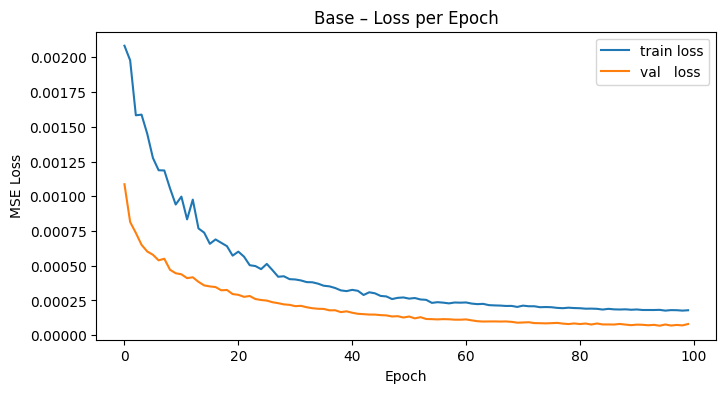

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


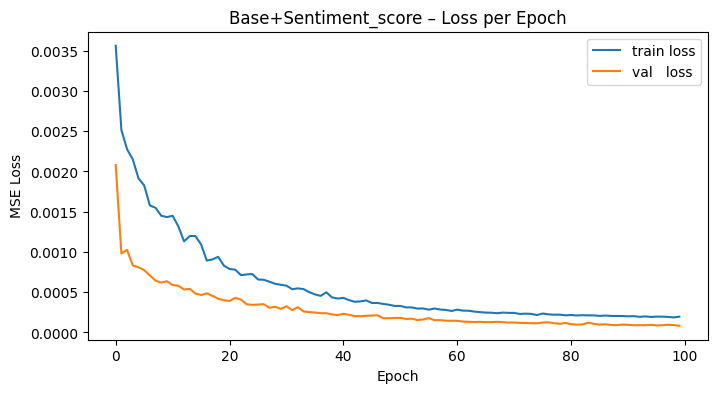

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


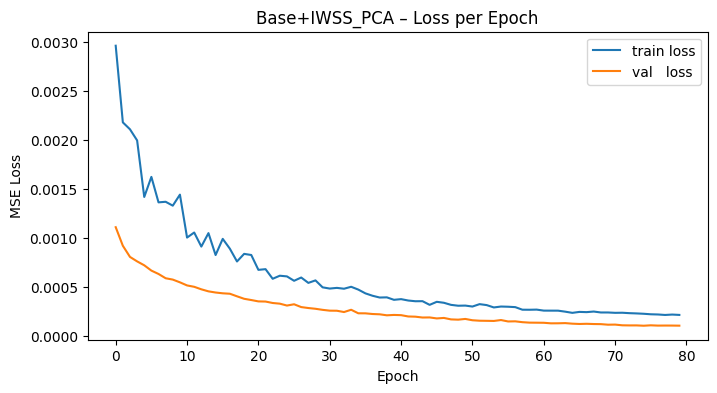

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


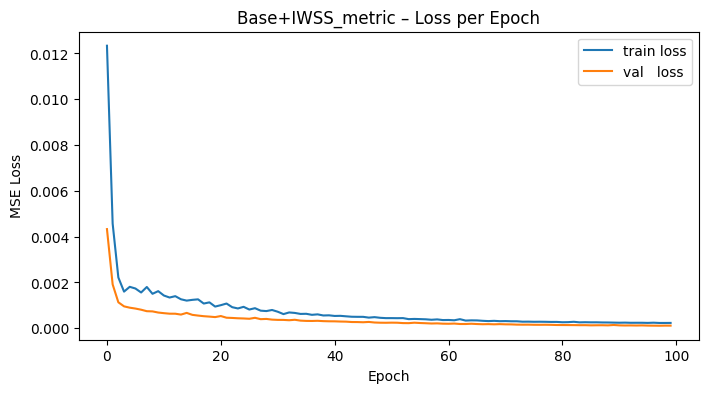

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


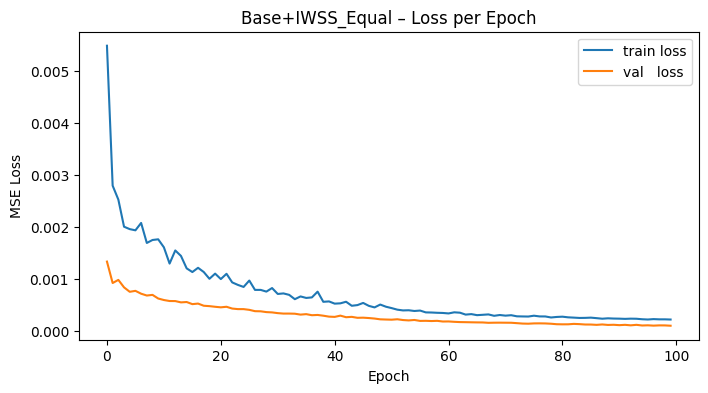

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


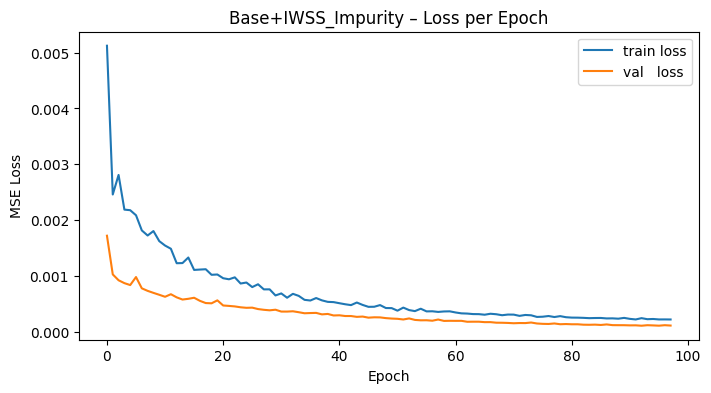

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


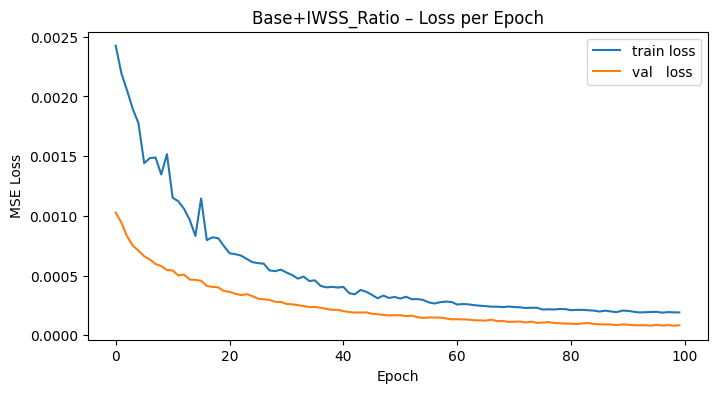

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


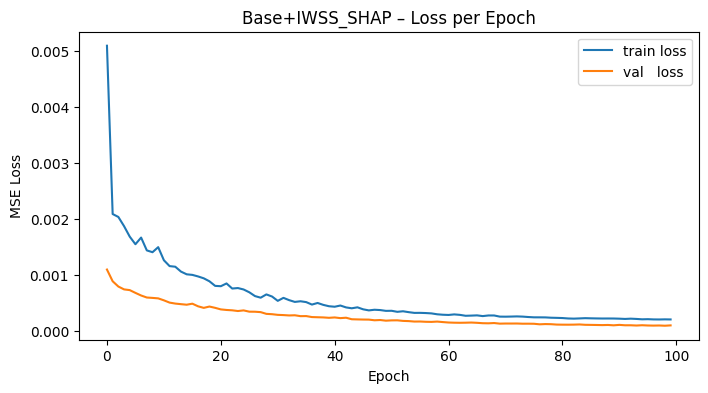

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


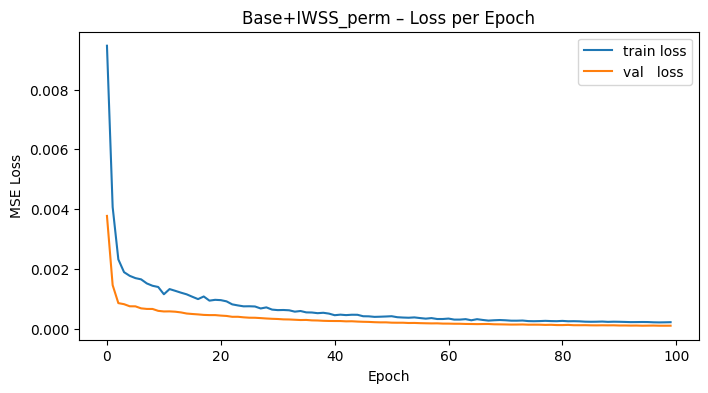

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
                  Model                  Config    Val R²      ROOS   Val MSE  \
5    Base+IWSS_Impurity  LSTM(50)+dropout+L2+ES  0.000728  0.062047  0.000049   
0                  Base  LSTM(50)+dropout+L2+ES -0.024201  0.038649  0.000050   
2         Base+IWSS_PCA  LSTM(50)+dropout+L2+ES -0.007051  0.054746  0.000049   
3      Base+IWSS_metric  LSTM(50)+dropout+L2+ES -0.034415  0.029062  0.000050   
4       Base+IWSS_Equal  LSTM(50)+dropout+L2+ES -0.036771  0.026850  0.000051   
8        Base+IWSS_perm  LSTM(50)+dropout+L2+ES -0.094224 -0.027078  0.000053   
6       Base+IWSS_Ratio  LSTM(50)+dropout+L2+ES -0.090945 -0.023999  0.000053   
1  Base+Sentiment_score  LSTM(50)+dropout+L2+ES -0.141177 -0.071150  0.000056   
7        Base+IWSS_SHAP  LSTM(50)+dropout+L2+ES -0.092870 -0.025807  0.000053   

    Val MAE  Val RMSE  Directional Accuracy (%)  Correct Predictions  Total  
5  0.005284  0.006980                 60.544218                   89    1

In [ ]:
# — assume df_train & df_val are already loaded & NA‐dropped —

TARGET = 'return_t+1'

# Your nine feature‐sets
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

results = []

for name, feats in feature_sets.items():
    # --- data prep ---
    X_tr = df_train[feats].values
    y_tr = df_train[TARGET].values
    X_val = df_val[feats].values
    y_val = df_val[TARGET].values

    scaler   = StandardScaler()
    X_tr_s    = scaler.fit_transform(X_tr)
    X_val_s   = scaler.transform(X_val)
    X_tr_r    = X_tr_s.reshape((-1, 1, X_tr_s.shape[1]))
    X_val_r   = X_val_s.reshape((-1, 1, X_val_s.shape[1]))

    # --- build model with dropout & L2 ---
    model = Sequential([
        Input(shape=(1, X_tr_r.shape[2])),
        LSTM(50,
             dropout=0.2,
             recurrent_dropout=0.2,
             kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(1, kernel_regularizer=l2(1e-4))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # --- early stopping ---
    es = EarlyStopping(monitor='val_loss',
                       patience=5,
                       restore_best_weights=True)

    history = model.fit(
        X_tr_r, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_r, y_val),
        callbacks=[es],
        verbose=0
    )

    # --- plot losses ---
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'],    label='train loss')
    plt.plot(history.history['val_loss'],label='val   loss')
    plt.title(f'{name} – Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # --- evaluate on validation ---
    y_pred = model.predict(X_val_r).flatten()
    res    = y_val - y_pred

    mse     = mean_squared_error(y_val, y_pred)
    mae     = mean_absolute_error(y_val, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_val, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_val - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_val)).sum()
    acc     = correct / len(y_val) * 100

    results.append({
        'Model': name,
        'Config':  'LSTM(50)+dropout+L2+ES',
        'Val R²':  r2,
        'ROOS':    roos,
        'Val MSE': mse,
        'Val MAE': mae,
        'Val RMSE':rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_val)
    })

# final results table
results_df = pd.DataFrame(results) \
                   .sort_values('Directional Accuracy (%)', ascending=False)
print(results_df)


In [ ]:
results_df

,Model,Config,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Directional Accuracy (%),Correct Predictions,Total
7,Base+IWSS_SHAP,LSTM(50)+dropout+L2+ES,0.003059,0.064235,0.000049,0.005293,0.006972,57.823129,85,147
8,Base+IWSS_perm,LSTM(50)+dropout+L2+ES,-0.041271,0.022626,0.000051,0.005423,0.007125,53.741497,79,147
2,Base+IWSS_PCA,LSTM(50)+dropout+L2+ES,-0.026098,0.036868,0.000050,0.005375,0.007073,53.741497,79,147
6,Base+IWSS_Ratio,LSTM(50)+dropout+L2+ES,-0.042265,0.021693,0.000051,0.005423,0.007129,51.020408,75,147
3,Base+IWSS_metric,LSTM(50)+dropout+L2+ES,-0.082927,-0.016474,0.000053,0.005573,0.007266,50.340136,74,147
4,Base+IWSS_Equal,LSTM(50)+dropout+L2+ES,-0.052311,0.012263,0.000051,0.005441,0.007163,50.340136,74,147
1,Base+Sentiment_score,LSTM(50)+dropout+L2+ES,-0.050707,0.013769,0.000051,0.005502,0.007158,48.299320,71,147
5,Base+IWSS_Impurity,LSTM(50)+dropout+L2+ES,-0.063147,0.002093,0.000052,0.005504,0.007200,47.619048,70,147
0,Base,LSTM(50)+dropout+L2+ES,-0.094329,-0.027176,0.000053,0.005622,0.007305,41.496599,61,147


In [ ]:
results_df

,Model,Config,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Directional Accuracy (%),Correct Predictions,Total
5,Base+IWSS_Impurity,LSTM(50)+dropout+L2+ES,0.000728,0.062047,0.000049,0.005284,0.006980,60.544218,89,147
0,Base,LSTM(50)+dropout+L2+ES,-0.024201,0.038649,0.000050,0.005384,0.007067,59.183673,87,147
2,Base+IWSS_PCA,LSTM(50)+dropout+L2+ES,-0.007051,0.054746,0.000049,0.005304,0.007007,58.503401,86,147
3,Base+IWSS_metric,LSTM(50)+dropout+L2+ES,-0.034415,0.029062,0.000050,0.005404,0.007102,57.823129,85,147
4,Base+IWSS_Equal,LSTM(50)+dropout+L2+ES,-0.036771,0.026850,0.000051,0.005402,0.007110,55.782313,82,147
8,Base+IWSS_perm,LSTM(50)+dropout+L2+ES,-0.094224,-0.027078,0.000053,0.005562,0.007304,47.619048,70,147
6,Base+IWSS_Ratio,LSTM(50)+dropout+L2+ES,-0.090945,-0.023999,0.000053,0.005587,0.007293,44.897959,66,147
1,Base+Sentiment_score,LSTM(50)+dropout+L2+ES,-0.141177,-0.071150,0.000056,0.005859,0.007459,42.857143,63,147
7,Base+IWSS_SHAP,LSTM(50)+dropout+L2+ES,-0.092870,-0.025807,0.000053,0.005618,0.007300,39.455782,58,147


# Prediction on test data

In [ ]:
df_test = df_test.dropna(subset="return_t+1" )
df_test['trading_day'] = pd.to_datetime(df_test['trading_day'])

<ipython-input-4-3f2d56c9bb2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trading_day'] = pd.to_datetime(df_test['trading_day'])


In [ ]:
# — assume df_train, df_val & df_test are already loaded & NA‐dropped —

TARGET = 'return_t+1'

# your nine feature‐sets
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

# fixed LSTM config
DROPOUT = 0.2
L2_REG  = 1e-4
PATIENCE = 5

test_results = []

for name, feats in feature_sets.items():
    # prepare arrays
    X_tr = df_train[feats].values;    y_tr = df_train[TARGET].values
    X_val= df_val[feats].values;      y_val= df_val[TARGET].values
    X_te = df_test[feats].values;     y_te = df_test[TARGET].values

    # scale on train
    scaler = StandardScaler().fit(X_tr)
    X_tr_s  = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_te_s  = scaler.transform(X_te)

    # reshape for LSTM
    X_tr_r  = X_tr_s.reshape(-1,1,X_tr_s.shape[1])
    X_val_r = X_val_s.reshape(-1,1,X_val_s.shape[1])
    X_te_r  = X_te_s.reshape(-1,1,X_te_s.shape[1])

    # build & compile model
    model = Sequential([
        Input(shape=(1, X_tr_r.shape[2])),
        LSTM(50,
             dropout=DROPOUT,
             recurrent_dropout=DROPOUT,
             kernel_regularizer=l2(L2_REG)),
        Dropout(DROPOUT),
        Dense(1, kernel_regularizer=l2(L2_REG))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # early stopping on val set
    es = EarlyStopping(monitor='val_loss',
                       patience=PATIENCE,
                       restore_best_weights=True,
                       verbose=0)

    # train
    model.fit(
        X_tr_r, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_r, y_val),
        callbacks=[es],
        verbose=0
    )

    # predict on test
    y_pred = model.predict(X_te_r).flatten()
    res    = y_te - y_pred

    # compute metrics
    mse     = mean_squared_error(y_te, y_pred)
    mae     = mean_absolute_error(y_te, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_te, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_te - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_te)).sum()
    acc     = correct / len(y_te) * 100

    test_results.append({
        'Model': name,
        'Config': 'LSTM(50)+dropout+L2+ES',
        'Test R²': r2,
        'Test ROOS': roos,
        'Test MSE': mse,
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_te)
    })

# display test‐set performance
test_df = pd.DataFrame(test_results) \
            .sort_values('Directional Accuracy (%)', ascending=False)
print(test_df)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
                  Model                  Config   Test R²  Test ROOS  \
8        Base+IWSS_perm  LSTM(50)+dropout+L2+ES -0.015655  -0.002815   
2         Base+IWSS_PCA  LSTM(50)+dropout+L2+ES  0.000682   0.013316   
5    Base+IWSS_Impurity  LSTM(50)+dropout+L2+ES -0.045402  -0.032186   
4       Base+IWSS_Equal  LSTM(50)+dropout+L2+ES -0.004230   0.008466   
7        Base+IWSS_SHAP  LSTM(50)+dropout+L2+ES  0.011524   0.024021   
0                  Base  LSTM(50)+dropout+L2+ES -0.034417  -0.021340   
1  Base+Sentiment_score  LSTM(50)+dropout+L2+ES -0.034832  -0.021749   
3      Base+IWSS_metric  LSTM(50)+dropout+L2+ES -0.033163  -0.020102   
6       B

In [ ]:
test_df

,Model,Config,Test R²,Test ROOS,Test MSE,Test MAE,Test RMSE,Directional Accuracy (%),Correct Predictions,Total
8,Base+IWSS_perm,LSTM(50)+dropout+L2+ES,-0.015655,-0.002815,0.000073,0.006111,0.008572,55.782313,82,147
2,Base+IWSS_PCA,LSTM(50)+dropout+L2+ES,0.000682,0.013316,0.000072,0.006142,0.008503,48.979592,72,147
5,Base+IWSS_Impurity,LSTM(50)+dropout+L2+ES,-0.045402,-0.032186,0.000076,0.006210,0.008697,48.299320,71,147
4,Base+IWSS_Equal,LSTM(50)+dropout+L2+ES,-0.004230,0.008466,0.000073,0.006220,0.008524,47.619048,70,147
7,Base+IWSS_SHAP,LSTM(50)+dropout+L2+ES,0.011524,0.024021,0.000072,0.006135,0.008457,46.258503,68,147
0,Base,LSTM(50)+dropout+L2+ES,-0.034417,-0.021340,0.000075,0.006306,0.008651,44.897959,66,147
1,Base+Sentiment_score,LSTM(50)+dropout+L2+ES,-0.034832,-0.021749,0.000075,0.006321,0.008653,44.217687,65,147
3,Base+IWSS_metric,LSTM(50)+dropout+L2+ES,-0.033163,-0.020102,0.000075,0.006377,0.008646,44.217687,65,147
6,Base+IWSS_Ratio,LSTM(50)+dropout+L2+ES,0.003284,0.015884,0.000072,0.006226,0.008492,43.537415,64,147


# Finetuning the parameters (Same model + changes)


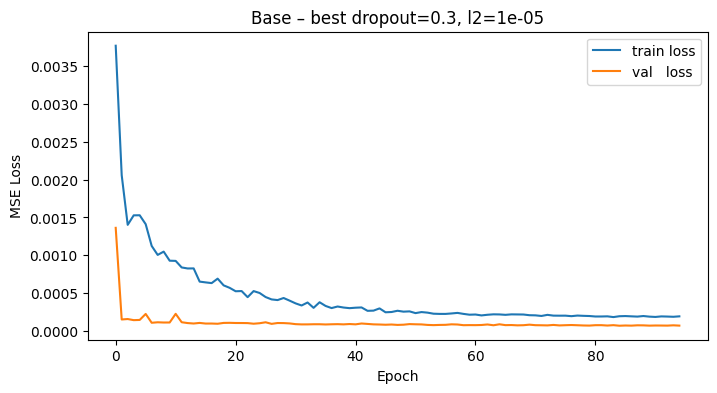

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


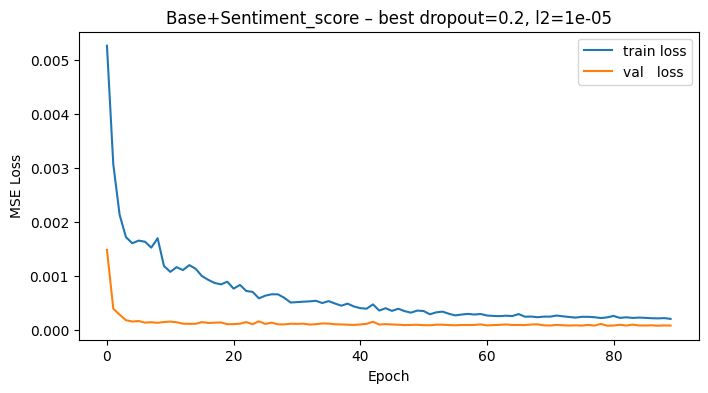

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


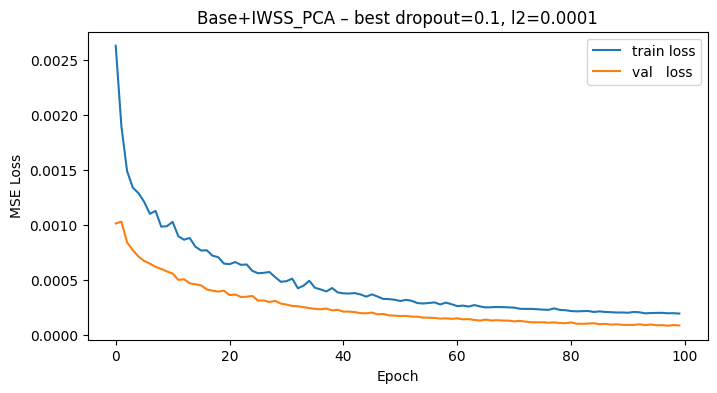

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


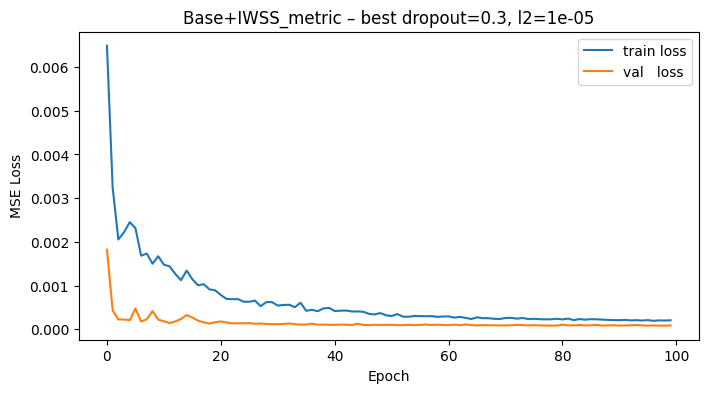

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


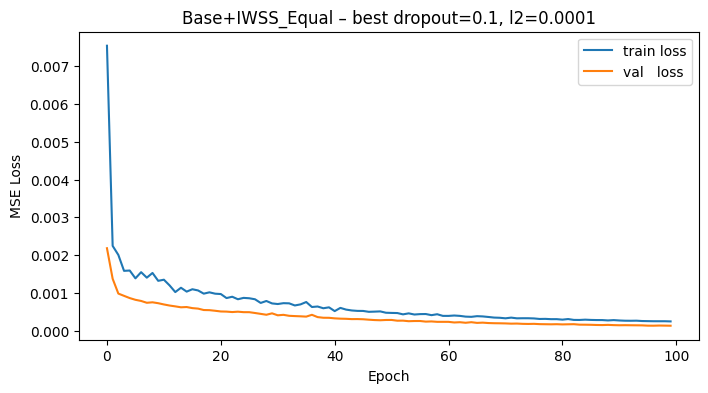

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


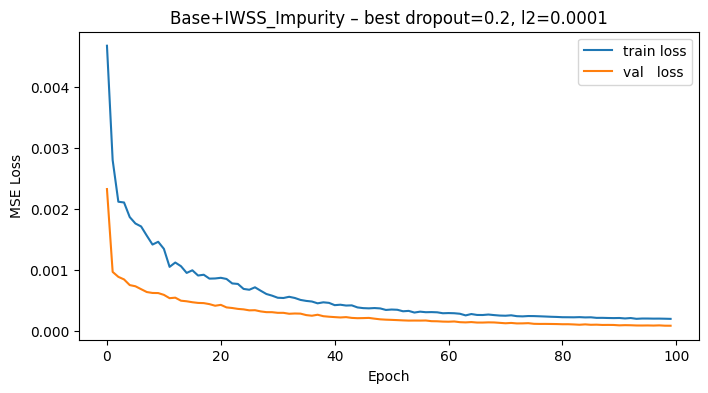

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


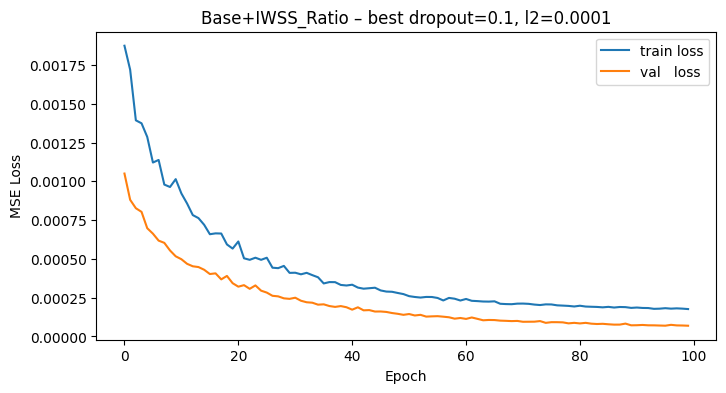

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


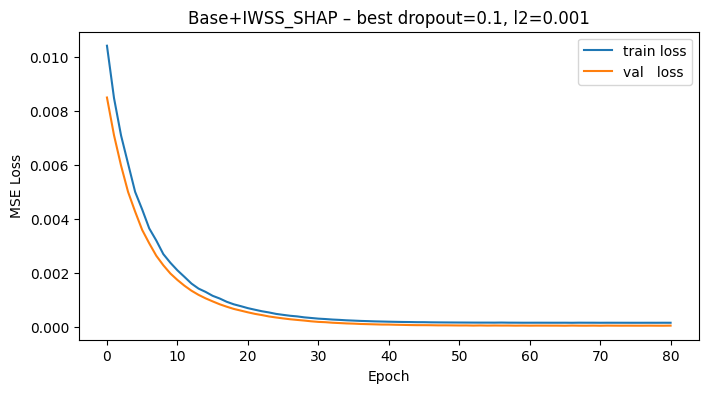

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


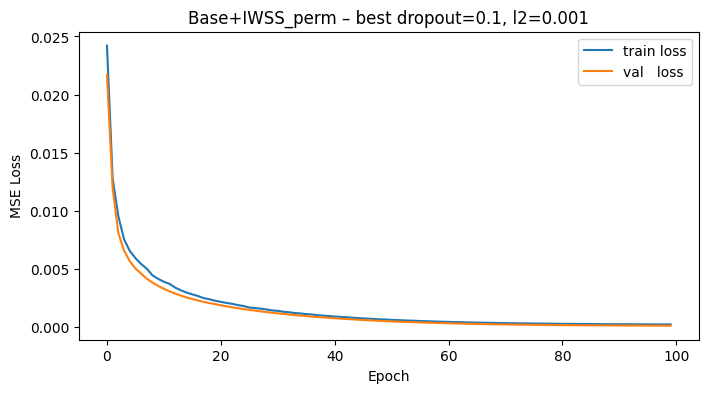

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
                  Model  dropout       l2    Val R²      ROOS   Val MSE  \
7        Base+IWSS_SHAP      0.1  0.00100 -0.023351  0.039446  0.000050   
8        Base+IWSS_perm      0.1  0.00100 -0.030237  0.032983  0.000050   
0                  Base      0.3  0.00001 -0.009609  0.052345  0.000049   
1  Base+Sentiment_score      0.2  0.00001 -0.039197  0.024572  0.000051   
2         Base+IWSS_PCA      0.1  0.00010 -0.039297  0.024479  0.000051   
5    Base+IWSS_Impurity      0.2  0.00010 -0.073424 -0.007554  0.000052   
3      Base+IWSS_metric      0.3  0.00001 -0.096576 -0.029285  0.000053   
6       Base+IWSS_Ratio      0.1  0.00010 -0.085987 -0.019346  0.000053   
4       Base+IWSS_Equal      0.1  0.00010 -0.126144 -0.057039  0.000055   

    Val MAE  Val RMSE  Directional Accuracy (%)  Correct Predictions  Total  
7  0.005385  0.007064                 59.863946                   88    147  
8  0.005402  0.007087                 59.863946        

In [ ]:
# — assume df_train & df_val are already loaded —

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

TARGET = 'return_t+1'

# your nine feature-sets
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

# the grid of dropout & L2 values to try
dropout_vals = [0.1, 0.2, 0.3]
l2_vals      = [1e-5, 1e-4, 1e-3]
patience     = 10

# custom directional accuracy metric for Keras
def directional_accuracy(y_true, y_pred):
    y_true_sign = K.sign(y_true)
    y_pred_sign = K.sign(y_pred)
    return K.mean(K.equal(y_true_sign, y_pred_sign))

results = []

for name, feats in feature_sets.items():
    # prepare & scale once per feature set
    X_tr = df_train[feats].values
    y_tr = df_train[TARGET].values
    X_val = df_val[feats].values
    y_val = df_val[TARGET].values

    scaler   = StandardScaler()
    X_tr_s   = scaler.fit_transform(X_tr)
    X_val_s  = scaler.transform(X_val)
    X_tr_r   = X_tr_s.reshape((-1, 1, X_tr_s.shape[1]))
    X_val_r  = X_val_s.reshape((-1, 1, X_val_s.shape[1]))

    best_acc = -np.inf
    best_cfg = {}

    # grid search over dropout & L2
    for dr in dropout_vals:
        for reg in l2_vals:
            # build model
            model = Sequential([
                Input(shape=(1, X_tr_r.shape[2])),
                LSTM(50,
                     dropout=dr,
                     recurrent_dropout=dr,
                     kernel_regularizer=l2(reg)),
                Dropout(dr),
                Dense(1, kernel_regularizer=l2(reg))
            ])
            model.compile(optimizer='adam',
                          loss='mse',
                          metrics=['mae', directional_accuracy])

            # train with patience=10
            es = EarlyStopping(monitor='val_loss',
                               patience=patience,
                               restore_best_weights=True,
                               verbose=0)

            history = model.fit(
                X_tr_r, y_tr,
                epochs=100,
                batch_size=32,
                validation_data=(X_val_r, y_val),
                callbacks=[es],
                verbose=0
            )

            # final val directional accuracy from history
            val_dir_acc = max(history.history['val_directional_accuracy'])

            if val_dir_acc > best_acc:
                best_acc = val_dir_acc
                best_cfg = {
                    'dropout': dr,
                    'l2': reg,
                    'history': history,
                    'model': model
                }

    # retrieve best run
    h = best_cfg['history']
    # plot its loss curve
    plt.figure(figsize=(8,4))
    plt.plot(h.history['loss'],     label='train loss')
    plt.plot(h.history['val_loss'], label='val   loss')
    plt.title(f'{name} – best dropout={best_cfg["dropout"]}, l2={best_cfg["l2"]}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # evaluate best model on val
    y_pred = best_cfg['model'].predict(X_val_r).flatten()
    res    = y_val - y_pred

    mse     = mean_squared_error(y_val, y_pred)
    mae     = mean_absolute_error(y_val, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_val, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_val - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_val)).sum()
    acc     = correct / len(y_val) * 100

    results.append({
        'Model': name,
        'dropout': best_cfg['dropout'],
        'l2': best_cfg['l2'],
        'Val R²': r2,
        'ROOS': roos,
        'Val MSE': mse,
        'Val MAE': mae,
        'Val RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_val)
    })

# compile results
results_df = pd.DataFrame(results) \
                   .sort_values('Directional Accuracy (%)', ascending=False)
print(results_df)

In [ ]:
results_df

,Model,dropout,l2,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Directional Accuracy (%),Correct Predictions,Total
7,Base+IWSS_SHAP,0.1,0.00100,-0.023351,0.039446,0.000050,0.005385,0.007064,59.863946,88,147
8,Base+IWSS_perm,0.1,0.00100,-0.030237,0.032983,0.000050,0.005402,0.007087,59.863946,88,147
0,Base,0.3,0.00001,-0.009609,0.052345,0.000049,0.005330,0.007016,58.503401,86,147
1,Base+Sentiment_score,0.2,0.00001,-0.039197,0.024572,0.000051,0.005458,0.007118,53.741497,79,147
2,Base+IWSS_PCA,0.1,0.00010,-0.039297,0.024479,0.000051,0.005442,0.007119,48.299320,71,147
5,Base+IWSS_Impurity,0.2,0.00010,-0.073424,-0.007554,0.000052,0.005529,0.007235,44.217687,65,147
3,Base+IWSS_metric,0.3,0.00001,-0.096576,-0.029285,0.000053,0.005658,0.007312,44.217687,65,147
6,Base+IWSS_Ratio,0.1,0.00010,-0.085987,-0.019346,0.000053,0.005570,0.007277,43.537415,64,147
4,Base+IWSS_Equal,0.1,0.00010,-0.126144,-0.057039,0.000055,0.005737,0.007410,39.455782,58,147


# Predicting on test data

In [ ]:
df_test = df_test.dropna(subset="return_t+1" )
df_test['trading_day'] = pd.to_datetime(df_test['trading_day'])

<ipython-input-6-3f2d56c9bb2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trading_day'] = pd.to_datetime(df_test['trading_day'])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# — assume df_train, df_val, df_test are already loaded & NaN‐dropped —

TARGET = 'return_t+1'

# your nine feature‐sets again
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

# grab the best dropout & l2 from your validation results_df
# (make sure you've run the validation‐grid code and have results_df in scope)
best_params = results_df.set_index('Model')[['dropout','l2']].to_dict('index')

test_results = []

for name, feats in feature_sets.items():
    dr  = best_params[name]['dropout']
    reg = best_params[name]['l2']

    # prepare arrays
    X_tr = df_train[feats].values;    y_tr = df_train[TARGET].values
    X_val= df_val[feats].values;      y_val= df_val[TARGET].values
    X_te = df_test[feats].values;     y_te = df_test[TARGET].values

    # scale on train only
    scaler = StandardScaler().fit(X_tr)
    X_tr_s  = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_te_s  = scaler.transform(X_te)

    # reshape for LSTM
    X_tr_r  = X_tr_s.reshape((-1,1,X_tr_s.shape[1]))
    X_val_r = X_val_s.reshape((-1,1,X_val_s.shape[1]))
    X_te_r  = X_te_s.reshape((-1,1,X_te_s.shape[1]))

    # build & compile
    model = Sequential([
        Input(shape=(1, X_tr_r.shape[2])),
        LSTM(50,
             dropout=dr,
             recurrent_dropout=dr,
             kernel_regularizer=l2(reg)),
        Dropout(dr),
        Dense(1, kernel_regularizer=l2(reg))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # early stopping (patience=10)
    es = EarlyStopping(monitor='val_loss',
                       patience=10,
                       restore_best_weights=True,
                       verbose=0)

    # train on train, monitor on val
    model.fit(
        X_tr_r, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_r, y_val),
        callbacks=[es],
        verbose=0
    )

    # predict on test
    y_pred = model.predict(X_te_r).flatten()
    res    = y_te - y_pred

    # compute metrics
    mse     = mean_squared_error(y_te, y_pred)
    mae     = mean_absolute_error(y_te, y_pred)
    rmse    = np.sqrt(mse)
    r2      = r2_score(y_te, y_pred)
    roos    = 1 - np.sum(res**2) / np.sum((y_te - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_te)).sum()
    acc     = correct / len(y_te) * 100

    test_results.append({
        'Model': name,
        'dropout': dr,
        'l2': reg,
        'Test R²': r2,
        'Test ROOS': roos,
        'Test MSE': mse,
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_te)
    })

# show test‐set performance
test_df = pd.DataFrame(test_results) \
            .sort_values('Directional Accuracy (%)', ascending=False)
print(test_df)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
                  Model  dropout       l2   Test R²  Test ROOS  Test MSE  \
7        Base+IWSS_SHAP      0.1  0.00100 -0.000728   0.011923  0.000072   
6       Base+IWSS_Ratio      0.1  0.00010  0.013082   0.025559  0.000071   
8        Base+IWSS_perm      0.1  0.00100  0.000197   0.012837  0.000072   
1  Base+Sentiment_score      0.2  0.00001 -0.033864  -0.020793  0.000075   
0                  Base      0.3  0.00001 -0.033095  -0.020034  0.000075   
3      Base+IWSS_metric      0.3  0.00001 -0.585445  -0.565402  0.000115   
2         Base+IWSS_PCA      0.1  0.00010 -0.042247  -0.029071  0.000075   
5    Base+IWSS_Impurity      0.2  0.00010 -0.02758

In [ ]:
test_df

,Model,dropout,l2,Test R²,Test ROOS,Test MSE,Test MAE,Test RMSE,Directional Accuracy (%),Correct Predictions,Total
7,Base+IWSS_SHAP,0.1,0.00100,-0.000728,0.011923,0.000072,0.006106,0.008509,58.503401,86,147
6,Base+IWSS_Ratio,0.1,0.00010,0.013082,0.025559,0.000071,0.006071,0.008450,58.503401,86,147
8,Base+IWSS_perm,0.1,0.00100,0.000197,0.012837,0.000072,0.006077,0.008505,58.503401,86,147
1,Base+Sentiment_score,0.2,0.00001,-0.033864,-0.020793,0.000075,0.006173,0.008649,55.782313,82,147
0,Base,0.3,0.00001,-0.033095,-0.020034,0.000075,0.006162,0.008645,54.421769,80,147
3,Base+IWSS_metric,0.3,0.00001,-0.585445,-0.565402,0.000115,0.007278,0.010710,51.700680,76,147
2,Base+IWSS_PCA,0.1,0.00010,-0.042247,-0.029071,0.000075,0.006360,0.008684,45.578231,67,147
5,Base+IWSS_Impurity,0.2,0.00010,-0.027581,-0.014590,0.000074,0.006286,0.008622,44.897959,66,147
4,Base+IWSS_Equal,0.1,0.00010,-0.027597,-0.014606,0.000074,0.006271,0.008622,44.217687,65,147


# Manually hard coded params from validation results

In [9]:
pip install tensorflow --quiet

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add.xlsx')
df_val = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add.xlsx')

df_train = df_train.dropna(subset="return_t" )
df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])

df_test = df_test.dropna(subset="return_t+1" )
df_test['trading_day'] = pd.to_datetime(df_test['trading_day'])

<ipython-input-3-43c53ae53a57>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])


In [36]:
# — assume df_train, df_val, df_test are already loaded & NaN‐dropped —

TARGET = 'return_t+1'

# your nine feature‐sets
feature_sets = {
    'Base':                  ['VIX','Volume','return_t'],
    'Base+Sentiment_score':  ['VIX','Volume','return_t','Sentiment_score'],
    'Base+IWSS_PCA':         ['VIX','Volume','return_t','IWSS_PCA'],
    'Base+IWSS_metric':      ['VIX','Volume','return_t','IWSS_metric'],
    'Base+IWSS_Equal':       ['VIX','Volume','return_t','IWSS_Equal'],
    'Base+IWSS_Impurity':    ['VIX','Volume','return_t','IWSS_Impurity'],
    'Base+IWSS_Ratio':       ['VIX','Volume','return_t','IWSS_Ratio'],
    'Base+IWSS_SHAP':        ['VIX','Volume','return_t','IWSS_SHAP'],
    'Base+IWSS_perm':        ['VIX','Volume','return_t','IWSS_perm'],
}

# manually specified best params from validation results
manual_params = {
    'Base':                   {'dropout': 0.3, 'l2': 1e-5},
    'Base+Sentiment_score':   {'dropout': 0.2, 'l2': 1e-5},
    'Base+IWSS_PCA':          {'dropout': 0.1, 'l2': 1e-4},
    'Base+IWSS_metric':       {'dropout': 0.3, 'l2': 1e-5},
    'Base+IWSS_Equal':        {'dropout': 0.1, 'l2': 1e-4},
    'Base+IWSS_Impurity':     {'dropout': 0.2, 'l2': 1e-4},
    'Base+IWSS_Ratio':        {'dropout': 0.1, 'l2': 1e-4},
    'Base+IWSS_SHAP':         {'dropout': 0.1, 'l2': 1e-3},
    'Base+IWSS_perm':         {'dropout': 0.1, 'l2': 1e-3},
}

# — only one seed now —
seed = 7
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# containers for later Diebold-Mariano use
forecast_errors = {name: [] for name in feature_sets}
predictions     = {name: [] for name in feature_sets}
actuals         = {}

# to collect metrics for printing
test_results = []

# Iterate through all feature sets
for name, feats in feature_sets.items():
    dr  = manual_params[name]['dropout']
    reg = manual_params[name]['l2']

    # Prepare data
    X_tr = df_train[feats].values; y_tr = df_train[TARGET].values
    X_val = df_val[feats].values;  y_val = df_val[TARGET].values
    X_te = df_test[feats].values;  y_te = df_test[TARGET].values

    # Scale using training data
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_te_s = scaler.transform(X_te)

    # Reshape for LSTM [samples, timesteps, features]
    X_tr_r = X_tr_s.reshape((-1, 1, X_tr_s.shape[1]))
    X_val_r = X_val_s.reshape((-1, 1, X_val_s.shape[1]))
    X_te_r = X_te_s.reshape((-1, 1, X_te_s.shape[1]))

    # Build LSTM model
    model = Sequential([
        Input(shape=(1, X_tr_r.shape[2])),
        LSTM(50, dropout=dr, recurrent_dropout=dr, kernel_regularizer=l2(reg)),
        Dropout(dr),
        Dense(1, kernel_regularizer=l2(reg))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Early stopping
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    # Train
    model.fit(X_tr_r, y_tr, epochs=100, batch_size=32,
              validation_data=(X_val_r, y_val), callbacks=[es], verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_te_r).flatten()
    res = y_te - y_pred

    # store the raw arrays
    forecast_errors[name].append(res)
    predictions    [name].append(y_pred)
    # actuals identical each seed, so only need to set once
    actuals.setdefault(name, y_te)

    # Compute metrics
    mse = mean_squared_error(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, y_pred)
    roos = 1 - np.sum(res**2) / np.sum((y_te - np.mean(y_tr))**2)
    correct = (np.sign(y_pred) == np.sign(y_te)).sum()
    acc = correct / len(y_te) * 100

    # Save metrics
    test_results.append({
        'Model': name,
        'dropout': dr,
        'l2': reg,
        'Test R²': r2,
        'Test ROOS': roos,
        'Test MSE': mse,
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Directional Accuracy (%)': acc,
        'Correct Predictions': int(correct),
        'Total': len(y_te)
    })


test_df = pd.DataFrame(test_results).sort_values('Directional Accuracy (%)', ascending=False)
print("\n=== Results for seed {seed} ===")
print(test_df)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

=== Results for seed {seed} ===
                  Model  dropout       l2   Test R²  Test ROOS  Test MSE  \
0                  Base      0.3  0.00001 -0.096428  -0.082567  0.000079   
1  Base+Sentiment_score      0.2  0.00001 -0.056760  -0.043400  0.000076   
4       Base+IWSS_Equal      0.1  0.00010 -0.020807  -0.007902  0.000074   
3      Base+IWSS_metric      0.3  0.00001 -0.075535  -0.061938  0.000078   
5    Base+IWSS_Impurity      0.2  0.00010 -0.032726  -0.019670  0.000075   
6       Base+IWSS_Ratio      0.1  0.00010 -0.031094  -0.018059  0.000075   
2         Base+IWSS_PCA      0.1  0.00010 -0.030334  -0.017308  0.000075   
7        Base+IW

In [28]:
from IPython.display import display, Markdown

display(Markdown(f"### **=== Results for seed {seed} ===**"))
display(test_df)

### **=== Results for seed 7 ===**

,Model,dropout,l2,Test R²,Test ROOS,Test MSE,Test MAE,Test RMSE,Directional Accuracy (%),Correct Predictions,Total
4,Base+IWSS_Equal,0.1,0.00010,0.004166,0.016756,0.000072,0.006090,0.008488,57.823129,85,147
3,Base+IWSS_metric,0.3,0.00001,-0.112957,-0.098887,0.000081,0.006538,0.008973,57.142857,84,147
0,Base,0.3,0.00001,-0.016795,-0.003940,0.000074,0.006106,0.008577,56.462585,83,147
5,Base+IWSS_Impurity,0.2,0.00010,-0.077594,-0.063971,0.000078,0.006363,0.008830,48.979592,72,147
1,Base+Sentiment_score,0.2,0.00001,-0.178945,-0.164040,0.000085,0.006837,0.009236,48.299320,71,147
8,Base+IWSS_perm,0.1,0.00100,-0.027406,-0.014418,0.000074,0.006325,0.008622,46.938776,69,147
2,Base+IWSS_PCA,0.1,0.00010,-0.030110,-0.017087,0.000075,0.006288,0.008633,46.258503,68,147
7,Base+IWSS_SHAP,0.1,0.00100,-0.024953,-0.011995,0.000074,0.006321,0.008611,44.217687,65,147
6,Base+IWSS_Ratio,0.1,0.00010,-0.091983,-0.078178,0.000079,0.006660,0.008888,41.496599,61,147


In [37]:
from IPython.display import display, Markdown

display(Markdown(f"### **=== Results for seed {seed} 100 epochs ===**"))
display(test_df)

### **=== Results for seed 7 100 epochs ===**

,Model,dropout,l2,Test R²,Test ROOS,Test MSE,Test MAE,Test RMSE,Directional Accuracy (%),Correct Predictions,Total
0,Base,0.3,0.00001,-0.096428,-0.082567,0.000079,0.006412,0.008907,48.979592,72,147
1,Base+Sentiment_score,0.2,0.00001,-0.056760,-0.043400,0.000076,0.006335,0.008744,47.619048,70,147
4,Base+IWSS_Equal,0.1,0.00010,-0.020807,-0.007902,0.000074,0.006312,0.008594,46.258503,68,147
3,Base+IWSS_metric,0.3,0.00001,-0.075535,-0.061938,0.000078,0.006440,0.008821,45.578231,67,147
5,Base+IWSS_Impurity,0.2,0.00010,-0.032726,-0.019670,0.000075,0.006230,0.008644,44.897959,66,147
6,Base+IWSS_Ratio,0.1,0.00010,-0.031094,-0.018059,0.000075,0.006279,0.008637,44.897959,66,147
2,Base+IWSS_PCA,0.1,0.00010,-0.030334,-0.017308,0.000075,0.006232,0.008634,44.217687,65,147
7,Base+IWSS_SHAP,0.1,0.00100,-0.016537,-0.003685,0.000074,0.006231,0.008576,41.496599,61,147
8,Base+IWSS_perm,0.1,0.00100,-0.017394,-0.004532,0.000074,0.006240,0.008580,41.496599,61,147


# Diebold mariano

In [34]:
# — Diebold–Mariano Test — #
def diebold_mariano_test(e1, e2, crit='MSE'):
    """
    e1, e2: 1D arrays of forecast errors
    crit: 'MSE' or 'MAE'
    """
    if crit == 'MSE':
        d = e1**2 - e2**2
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    n = len(d)
    mean_d = np.mean(d)
    std_d  = np.std(d, ddof=1)
    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(abs(dm_stat), df=n-1))
    return dm_stat, p_value

# Prepare list of IWSS models
iwss_models = [m for m in forecast_errors if 'IWSS' in m]
sent_errors = forecast_errors['Base+Sentiment_score'][0]
base_errors = forecast_errors['Base'][0]

dm_results = []

# IWSS vs Sentiment
for model_name in iwss_models:
    e1 = forecast_errors[model_name][0]           # unpack the single array
    dm_stat, p_val = diebold_mariano_test(e1, sent_errors, crit='MSE')
    dm_results.append({
        'Comparison': f'{model_name} vs Sentiment_score',
        'DM Statistic': dm_stat,
        'p-value': p_val,
        'Better': 'Sentiment_score' if dm_stat > 0 else model_name,
        'Significant': p_val < 0.05
    })

# IWSS vs Base
for model_name in iwss_models:
    e1 = forecast_errors[model_name][0]
    dm_stat, p_val = diebold_mariano_test(e1, base_errors, crit='MSE')
    dm_results.append({
        'Comparison': f'{model_name} vs Base',
        'DM Statistic': dm_stat,
        'p-value': p_val,
        'Better': 'Base' if dm_stat > 0 else model_name,
        'Significant': p_val < 0.05
    })

# Pairwise IWSS
for i, m_a in enumerate(iwss_models):
    for m_b in iwss_models[i+1:]:
        e1 = forecast_errors[m_a][0]
        e2 = forecast_errors[m_b][0]
        dm_stat, p_val = diebold_mariano_test(e1, e2, crit='MSE')
        better = m_a if dm_stat > 0 else m_b
        dm_results.append({
            'Comparison': f'{m_a} vs {m_b}',
            'DM Statistic': dm_stat,
            'p-value': p_val,
            'Better': better,
            'Significant': p_val < 0.05
        })

dm_df = pd.DataFrame(dm_results).sort_values('p-value')

In [35]:
dm_df

,Comparison,DM Statistic,p-value,Better,Significant
0,Base+IWSS_PCA vs Sentiment_score,-3.191771,0.001732,Base+IWSS_PCA,True
5,Base+IWSS_SHAP vs Sentiment_score,-2.844607,0.005086,Base+IWSS_SHAP,True
6,Base+IWSS_perm vs Sentiment_score,-2.813702,0.005573,Base+IWSS_perm,True
2,Base+IWSS_Equal vs Sentiment_score,-2.662950,0.008615,Base+IWSS_Equal,True
32,Base+IWSS_Ratio vs Base+IWSS_SHAP,2.528619,0.012514,Base+IWSS_Ratio,True
33,Base+IWSS_Ratio vs Base+IWSS_perm,2.461283,0.015009,Base+IWSS_Ratio,True
26,Base+IWSS_Equal vs Base+IWSS_Ratio,-2.405715,0.017392,Base+IWSS_Ratio,True
25,Base+IWSS_Equal vs Base+IWSS_Impurity,-1.824793,0.070076,Base+IWSS_Impurity,False
11,Base+IWSS_Ratio vs Base,1.693619,0.092470,Base,False
20,Base+IWSS_metric vs Base+IWSS_Equal,1.634164,0.104379,Base+IWSS_metric,False
